# Tutorial 2 - Decision Tree - Classification


We will predict the price category, among 4 categories, of an AIRBNB listing (`price_category` column). This is a multi-class classification task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)

# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

host_is_superhost  host_identity_verified neighbourhood_cleansed  \
0                  0                       0             Roslindale   
1                  0                       1             Roslindale   
2                  1                       1             Roslindale   
3                  0                       0             Roslindale   
4                  1                       1             Roslindale   

    latitude  longitude property_type        room_type  accommodates  \
0  42.282619 -71.133068         House  Entire home/apt             4   
1  42.286241 -71.134374     Apartment     Private room             2   
2  42.292438 -71.135765     Apartment     Private room             2   
3  42.281106 -71.121021         House     Private room             4   
4  42.284512 -71.136258         House     Private room             2   

   bathrooms  bedrooms  ...  guests_included price_per_extra_person  \
0        1.5       2.0  ...                1                      0   
1        1.0       1.0  ...                0                      0   
2        1.0       1.0  ...                1                     20   
3        1.0       1.0  ...                2                     25   
4        1.5       1.0  ...                1                      0   

   minimum_nights  number_of_reviews  number_days_btw_first_last_review  \
0               2                  0                                  0   
1               2                 36                                804   
2               3                 41                               2574   
3               1                  1                                  0   
4               2                 29                                380   

   review_scores_rating  cancellation_policy  price  price_gte_150  \
0                   NaN             moderate    250              1   
1                  94.0             moderate     65              0   
2                  98.0             moderate     65              0   
3                 100.0             moderate     75              0   
4                  99.0             flexible     79              0   

  price_category  
0        gte_226  
1         lte_75  
2         lte_75  
3         lte_75  
4     btw_75-150  

[5 rows x 23 columns]

# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                       0
host_identity_verified                  0
neighbourhood_cleansed                  0
latitude                                0
longitude                               0
property_type                           8
room_type                               0
accommodates                            0
bathrooms                              19
bedrooms                               19
beds                                   16
bed_type                                0
Number of amenities                     0
guests_included                         0
price_per_extra_person                  0
minimum_nights                          0
number_of_reviews                       0
number_days_btw_first_last_review       0
review_scores_rating                 1609
cancellation_policy                     0
price                                   0
price_gte_150                           0
price_category                          0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                             17
bedrooms                              11
beds                                   8
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 674
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [8]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks
# 'price' is regression continuous
# 'price_gte_150' multi-class

train = train_set.drop(['price', 'price_gte_150'], axis=1)
test = test_set.drop(['price', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [9]:
train_y = train['price_category']
test_y = test['price_category']

train_inputs = train.drop(['price_category'], axis=1)
test_inputs = test.drop(['price_category'], axis=1)

## Feature Engineering: Let's derive a new column

#### Create a new binary column: if there is extra price per person, it is 1, otherwise, 0

In [10]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['extra_price'] = np.where(df1['price_per_extra_person'] > 0, 1, 0)
    
    return df1[['extra_price']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [11]:
#Let's test the new function:

# Send train set to the function we created
new_col(train_set)

extra_price
3437            1
6622            0
2262            1
2246            0
835             1
...           ...
5734            0
5191            0
5390            0
860             1
7270            0

[7190 rows x 1 columns]

##  Identify the numerical and categorical columns

In [12]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [13]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [14]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [15]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [16]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [17]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [18]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [19]:
feat_eng_columns = ['price_per_extra_person']

# Pipeline

In [20]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [21]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [23]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col))])

In [24]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [25]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[-2.10940159, -1.39824237,  1.20477863, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.61906783, -1.38593382, -1.16133947, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14448465, -0.16705969, -1.16133947, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.82039585,  0.74441303, -0.56980994, ...,  0.        ,
         0.        ,  0.        ],
       [-0.92762441,  0.3821493 , -0.56980994, ...,  0.        ,
         1.        ,  1.        ],
       [-0.34071414, -0.53929512, -1.16133947, ...,  0.        ,
         0.        ,  0.        ]])

In [26]:
train_x.shape

(7190, 62)

# Tranform: transform() for TEST

In [27]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[ 0.63069768,  0.40533687,  1.79630816, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.15153485,  0.27611111, -0.56980994, ...,  0.        ,
         1.        ,  0.        ],
       [-2.02789334, -0.91924215,  0.02171958, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.15906806, -0.38872897,  1.20477863, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.11838687, -0.56878308, -0.56980994, ...,  0.        ,
         0.        ,  1.        ],
       [-0.94171792,  0.19283558, -1.16133947, ...,  0.        ,
         1.        ,  0.        ]])

In [28]:
test_x.shape

(3082, 62)

# Baseline

In [29]:
train_y.value_counts()/len(train_y)

btw_75-150     0.332823
btw_151-225    0.241725
lte_75         0.214743
gte_226        0.210709
Name: price_category, dtype: float64

# Multiclass classification

Do NOT train a DecisionTreeClassifier() without any parameters. It OVERFITS. 

In [30]:
from sklearn.tree import DecisionTreeClassifier 

tree_clf = DecisionTreeClassifier(min_samples_leaf=10)

tree_clf.fit(train_x, train_y)

DecisionTreeClassifier(min_samples_leaf=10)

# Accuracy

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
#Train accuracy:
train_y_pred = tree_clf.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.8208623087621697


In [33]:
#Test accuracy:
test_y_pred = tree_clf.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.72680077871512


# Classification Matrix

In [34]:
from sklearn.metrics import confusion_matrix

#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[462, 110, 113,  19],
       [133, 827,  36, 103],
       [111,  58, 501,   5],
       [ 11, 141,   2, 450]], dtype=int64)

## Classification Report

In [35]:
from sklearn.metrics import classification_report

print(classification_report(test_y, test_y_pred))

              precision    recall  f1-score   support

 btw_151-225       0.64      0.66      0.65       704
  btw_75-150       0.73      0.75      0.74      1099
     gte_226       0.77      0.74      0.76       675
      lte_75       0.78      0.75      0.76       604

    accuracy                           0.73      3082
   macro avg       0.73      0.72      0.73      3082
weighted avg       0.73      0.73      0.73      3082



## Plot the Tree

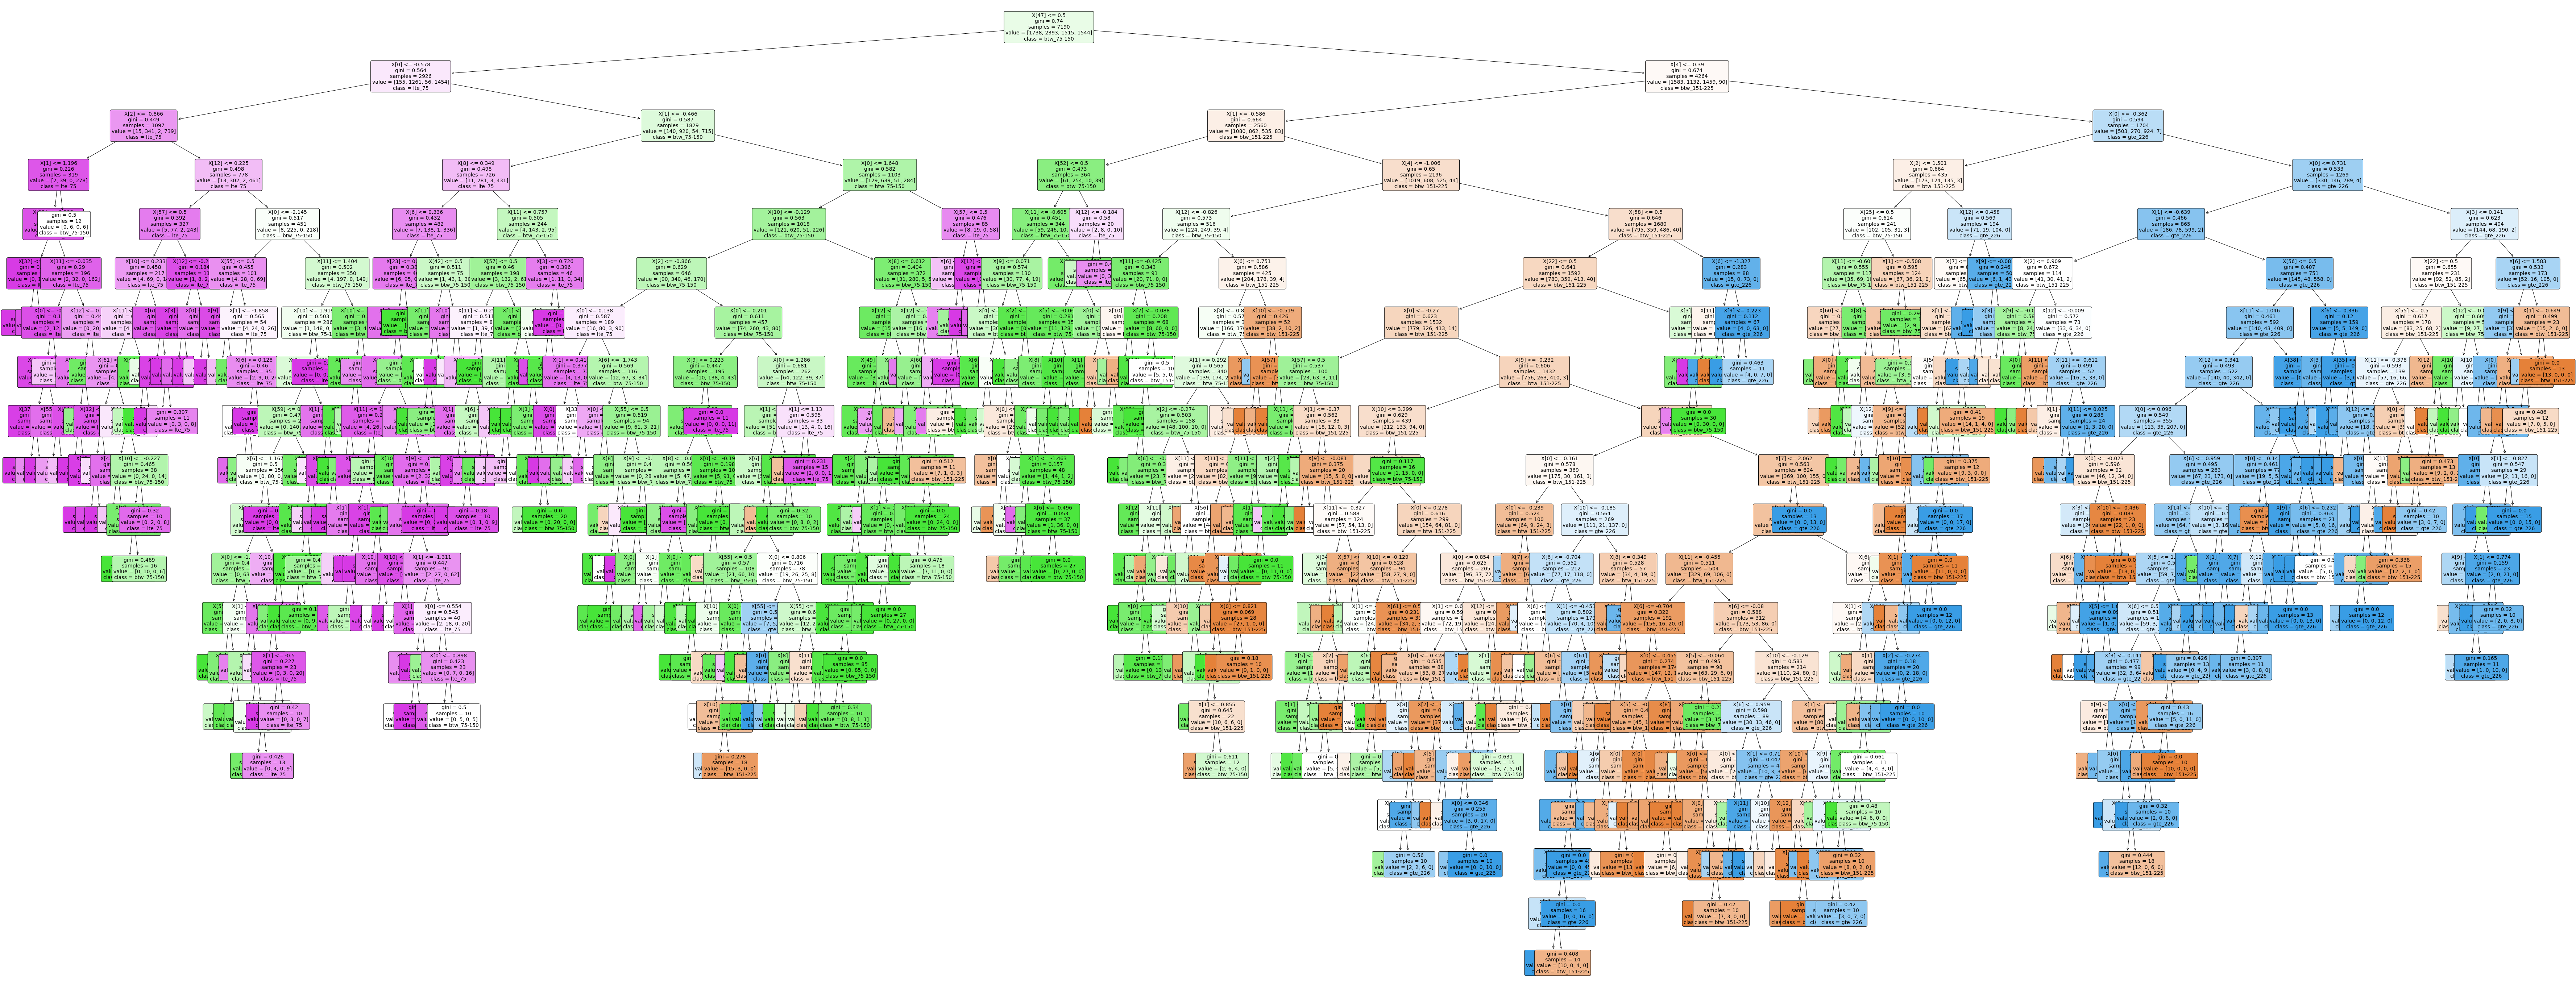

In [36]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))

tree = plot_tree(tree_clf, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=np.unique(train_y), 
              filled=True, 
              rounded=True, 
              fontsize=14)

## Regularization

Let's limit the depth

In [37]:
tree_clf2 = DecisionTreeClassifier(min_samples_leaf = 10, max_depth=5)

tree_clf2.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [38]:
#Train accuracy:
train_y_pred = tree_clf2.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.6127955493741307


In [39]:
#Test accuracy:
test_y_pred = tree_clf2.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.5950681375730046


In [40]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[482,  88, 115,  19],
       [317, 630,  28, 124],
       [276,  43, 355,   1],
       [ 15, 222,   0, 367]], dtype=int64)

## Prediction probabilities

In [41]:
#Select a random observation

random = test_x[50:51]
random

array([[ 0.44671982,  0.71670022,  0.61324911,  1.89706592,  1.08766162,
         0.4710924 ,  0.02385204, -0.40589026, -0.57249234, -0.00472628,
        -0.33824687,  1.57366607,  0.51641975,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ]])

In [42]:
# Observe the input variables of the observation
tree_clf2.predict_proba(random)

array([[0.1930759 , 0.06391478, 0.74300932, 0.        ]])

In [44]:
# Round the probability values
np.round(tree_clf2.predict_proba(random),2)

array([[0.19, 0.06, 0.74, 0.  ]])

## Change to entropy

In [53]:
tree_clf3 = DecisionTreeClassifier(min_samples_leaf = 10, criterion='entropy')
tree_clf3.fit(train_x, train_y)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10)

In [54]:
#Train accuracy:
train_y_pred = tree_clf3.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.8318497913769124


In [55]:
#Test accuracy:
test_y_pred = tree_clf3.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.7332900713822194


In [49]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[485, 104,  97,  18],
       [134, 815,  43, 107],
       [105,  57, 509,   4],
       [ 11, 135,   5, 453]], dtype=int64)

# Randomized Grid Search

Grid Search helps us try out a combination of different hyperparameters (sometimes randomly)

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {'max_depth': randint(low=5, high=20), 
              'min_samples_leaf': randint(low=5, high=20)}

tree_gs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                             n_iter=15, cv=5, verbose=1,
                             scoring='accuracy',
                             return_train_score=True)

tree_gs.fit(train_x, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=15,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019FB5917E20>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019FAD9C9F10>},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [57]:
cvres = tree_gs.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7211404728789986 {'max_depth': 14, 'min_samples_leaf': 7}
0.668567454798331 {'max_depth': 10, 'min_samples_leaf': 12}
0.6881780250347705 {'max_depth': 15, 'min_samples_leaf': 13}
0.6666203059805285 {'max_depth': 17, 'min_samples_leaf': 19}
0.664951321279555 {'max_depth': 11, 'min_samples_leaf': 16}
0.6382475660639777 {'max_depth': 7, 'min_samples_leaf': 5}
0.6424200278164116 {'max_depth': 8, 'min_samples_leaf': 17}
0.6837273991655077 {'max_depth': 10, 'min_samples_leaf': 7}
0.7518776077885952 {'max_depth': 18, 'min_samples_leaf': 5}
0.6524339360222531 {'max_depth': 10, 'min_samples_leaf': 18}
0.591655076495132 {'max_depth': 5, 'min_samples_leaf': 13}
0.6699582753824757 {'max_depth': 15, 'min_samples_leaf': 18}
0.7460361613351878 {'max_depth': 16, 'min_samples_leaf': 5}
0.7048678720445062 {'max_depth': 17, 'min_samples_leaf': 10}
0.5910987482614742 {'max_depth': 5, 'min_samples_leaf': 16}


In [58]:
#Find the best parameter set
tree_gs.best_params_

{'max_depth': 18, 'min_samples_leaf': 5}

In [59]:
tree_gs.best_estimator_

DecisionTreeClassifier(max_depth=18, min_samples_leaf=5)

In [60]:
#Train accuracy:
train_y_pred = tree_gs.best_estimator_.predict(train_x)

print(accuracy_score(train_y, train_y_pred))

0.890403337969402


In [61]:
#Test accuracy:
test_y_pred = tree_gs.best_estimator_.predict(test_x)

print(accuracy_score(test_y, test_y_pred))

0.7748215444516547


In [62]:
#Test confusion matrix
confusion_matrix(test_y, test_y_pred)

array([[486,  87, 117,  14],
       [ 90, 901,  32,  76],
       [108,  39, 523,   5],
       [ 26,  98,   2, 478]], dtype=int64)